# Text classification

This notebook goes through the basics of logistic regression and text classification with sklearn. Please do this lab if this is your first course in machine learning.

In [1]:
# imports

import os, codecs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic regression

* **Regression**: predict real/continuous values given inputs.
* **Classification**: predict categorical values from a finte set, given inputs.

Model:

$\hat{y} = \frac{1}{1 + e^{-(Xw )}}$

## The sigmoid

In [2]:
# shape of a sigmoid function
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

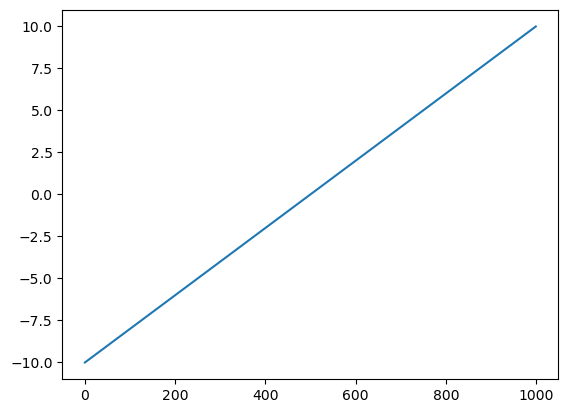

In [3]:
plt.plot(np.linspace(-10,10,1000))

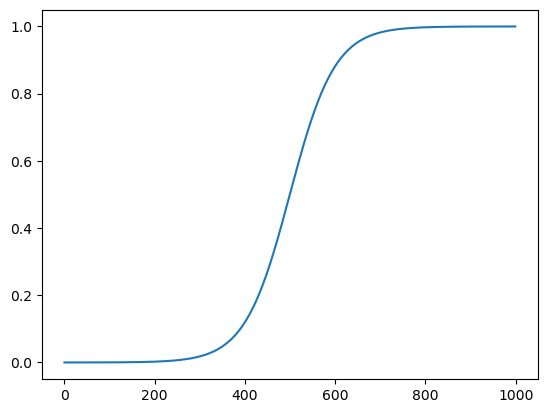

In [4]:
plt.plot([sigmoid(x) for x in np.linspace(-10,10,1000)])

## A toy example

In [5]:
# Let us use a toy example

from sklearn.datasets import make_classification # a simpler way to create classification data
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)

In [6]:
X.shape

(1000, 2)

In [7]:
np.unique(y)

array([0, 1])

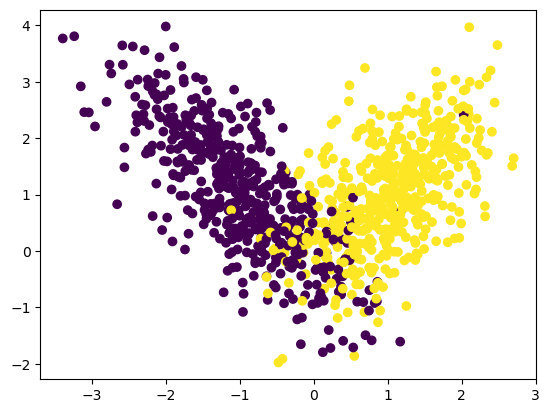

In [8]:
plt.scatter(X[:,0], X[:,1], c=y)

## SGD

Solving using stochastic gradient descent. It turns out that the derivative for one data point $x$ is (w.o. regularization):

$$
\frac{\partial \mathcal{L}_{x}(w)}{\partial w_j} = \big[ \sigma(wx) -y\big]x_j
$$

In [9]:
# add column for intercept parameter
X_mod = np.hstack((np.ones((X.shape[0],1)),X))
X_mod

array([[ 1.        , -0.4002285 , -0.92688039],
       [ 1.        ,  1.07610199,  1.18029069],
       [ 1.        , -0.92295314,  0.30616655],
       ...,
       [ 1.        , -2.37673965,  3.03728951],
       [ 1.        , -1.07726236,  1.45397626],
       [ 1.        ,  1.38028997,  0.87341245]])

In [10]:
from scipy.special import expit

def classify(y_hat):
    # threshold for logistic predictions
    return y_hat > 0.5

eta = 0.005 # learning rate
w_new = np.random.random(X.shape[1])
updates = list()

# with SGD, we iterate one point at the time
for n,(x_n,y_n) in enumerate(zip(X,y)):
    # calculate gradient
    gw = np.multiply((sigmoid(np.dot(x_n,w_new)) - y_n),x_n)
    w_prev = w_new
    # update weights
    w_new = w_prev - np.multiply(eta,gw)
    updates.append(np.sum(np.abs(y - expit(np.dot(X,w_new)))))
    if n % 100 == 0 and n>0: # every 100 steps, assess progress
        print("Number of prediction errors on training set at iteration %d:"%n,np.sum(np.abs(y - classify(expit(np.dot(X,w_new))))))

Number of prediction errors on training set at iteration 100: 365
Number of prediction errors on training set at iteration 200: 237
Number of prediction errors on training set at iteration 300: 147
Number of prediction errors on training set at iteration 400: 118
Number of prediction errors on training set at iteration 500: 104
Number of prediction errors on training set at iteration 600: 94
Number of prediction errors on training set at iteration 700: 84
Number of prediction errors on training set at iteration 800: 78
Number of prediction errors on training set at iteration 900: 78


Text(0.5, 0, 'Number of steps')

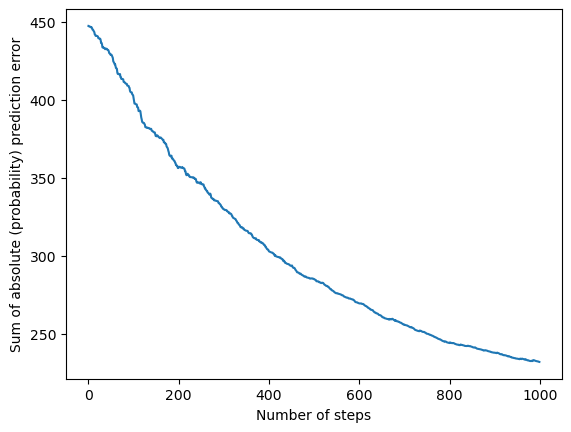

In [11]:
how_many = 1000

plt.plot(updates[:how_many])
plt.ylabel("Sum of absolute (probability) prediction error")
plt.xlabel("Number of steps")

It looks very much like we converge rather quickly, with 100-200 datapoints, and then we oscillate due to data points which cannot be all classified with a single decision boundary.

*Do try to change the learning rate and see what happens.*

Let us use Sklearn and plot the decision boundary:

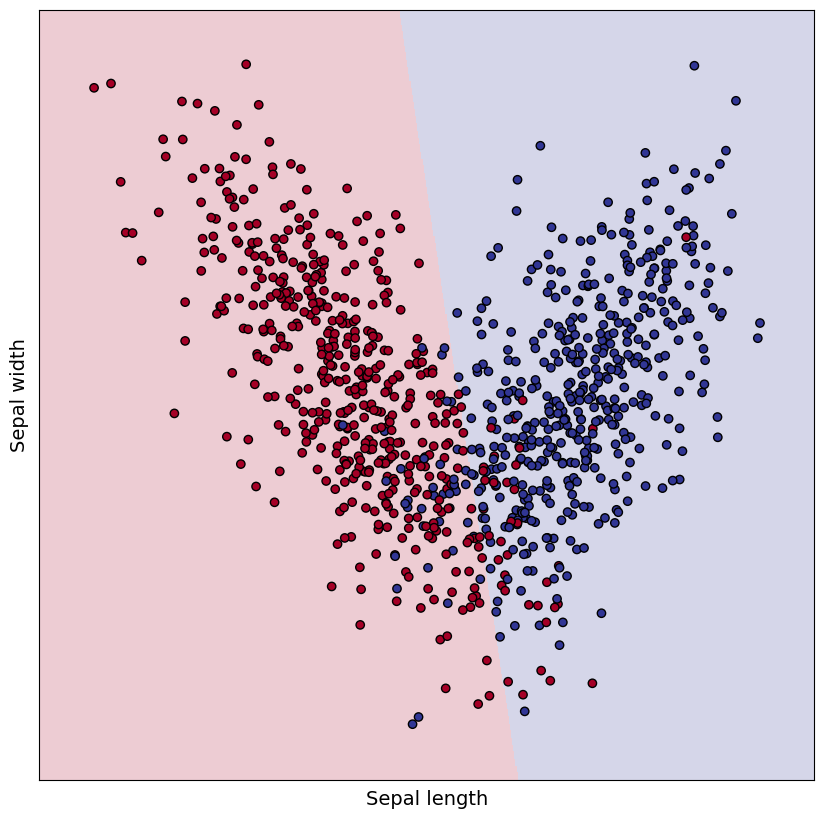

In [12]:
# From: https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.2, shading='auto')

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)
plt.xlabel('Sepal length', fontsize=14)
plt.ylabel('Sepal width', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

---

# A "real" example: Tesla vs SpaceX tweets

We use a dataset of tweets from Elon Musk, and train a classifier to distinguish between those which talk about SpaceX and those about Tesla.

In [16]:
import spacy
import nltk
import string
import sklearn

In [17]:
# load the dataset

root_folder = "data"
df_elon = pd.read_csv(codecs.open(os.path.join(root_folder,"elonmusk_tweets.csv"), encoding="utf8"), sep=",")

In [18]:
df_elon.head(5)

,id,created_at,text
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa..."
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'"
3,848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...'
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ..."


In [19]:
# Filter to just Tesla or SpaceX

def classify_t_or_s(tweet):
    
    if type(tweet) == str and "@SpaceX" in tweet:
        return 1
    elif type(tweet) == str and "@TeslaMotors" in tweet:
        return 0
    return -1

def remove_t_or_s(tweet):
    
    if type(tweet) == str:
        removed = tweet.replace("@SpaceX","")
        removed = removed.replace("@TeslaMotors","")
        return removed
    return ""

In [20]:
# Create classes and remove the discriminative token
df_elon["class"] = df_elon["text"].apply(classify_t_or_s)
df_elon["clean_text_rm"] = df_elon["text"].apply(remove_t_or_s)

*Why do we need to remove the discriminative token?*

In [21]:
df_elon[df_elon["class"] == 1].head(5)

,id,created_at,text,class,clean_text_rm
11,848239664536223745,2017-04-01 18:24:30,b'RT @ProfBrianCox: This is extremely importan...,1,b'RT @ProfBrianCox: This is extremely importan...
22,847610880506208257,2017-03-31 00:45:56,b'RT @SpaceX: More photos from today\xe2\x80\x...,1,b'RT : More photos from today\xe2\x80\x99s Fal...
23,847608431582208000,2017-03-31 00:36:12,b'@BadAstronomer @SpaceX Thanks Phil!',1,b'@BadAstronomer Thanks Phil!'
25,847580067446345728,2017-03-30 22:43:30,b'RT @SpaceX: Falcon 9 first stage has landed ...,1,b'RT : Falcon 9 first stage has landed on Of C...
26,847561780532523008,2017-03-30 21:30:50,b'RT @SpaceX: ~60 minutes until launch window ...,1,b'RT : ~60 minutes until launch window for SES...


In [22]:
df_reduced = df_elon[df_elon["class"] != -1]
df_reduced.shape

(316, 5)

In [23]:
# let's create the count representation of the dataset

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(tokenizer=tknzr.tokenize)
X = count_vect.fit_transform(df_reduced.clean_text_rm)
X.shape

(316, 1864)

In [24]:
y = df_reduced["class"].values

In [25]:
logreg = LogisticRegression(solver='lbfgs')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, y)

LogisticRegression()

In [26]:
# Try it out

test_tweet1 = "Let's all go to Mars and colonize!"
test_tweet2 = "Let's all go to Mars on with an electric car with auto pilot"
x = count_vect.transform([test_tweet1])
print(logreg.predict(x)[0])
print(logreg.predict_proba(x)[0])

1
[0.43819941 0.56180059]


In [27]:
x

<1x1864 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

*But, does it actually work?*

## Evaluation

### Exploratory vs confirmatory modelling

"Traditionally, the focus of modelling is on *inference, or for confirming that an hypothesis is "true"*. Doing this correctly is not complicated, but it is hard. There is a pair of ideas that you must understand in order to do inference correctly:

* Each observation can either be used for exploration or confirmation, not both.

* You can use an observation as many times as you like for exploration, but you can only use it once for confirmation. As soon as you use an observation twice, you’ve switched from confirmation to exploration.

This is necessary because to confirm a hypothesis you must use data independent of the data that you used to generate the hypothesis. Otherwise you will be over optimistic. There is absolutely nothing wrong with exploration, but you should never sell an exploratory analysis as a confirmatory analysis because it is fundamentally misleading.

If you are serious about doing an confirmatory analysis, one approach is to split your data into three pieces before you begin the analysis:

* 60% of your data goes into a **training** (or exploration) set. You’re allowed to do anything you like with this data: visualise it and fit tons of models to it.

* 20% goes into a **dev** or validation set. You can use this data to compare models or visualisations by hand, but you’re not allowed to use it as part of an automated process.

* 20% is held back for a **test** set. You can only use this data once, to test your final model.

This partitioning allows you to explore the training data, occasionally generating candidate hypotheses that you check with the query set. When you are confident you have the right model, you can check it once with the test data."

Note: the actual % depend on your data availability: the more data you have, the smaller the test and dev sets need to be.

https://r4ds.had.co.nz/model-intro.html

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [29]:
logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)

# evaluate using accuracy: proportion of correctly predicted over total
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

0.8315789473684211
79


We are doing quite well already.

## Exercises

* Try to improve the model tuning your hyperparameters or its pre-processing, and test against the dev set. When you are happy, do a final evaluation against the test set.
* Add Precision and Recall to the evaluation above. Hint: see the `precision_score` and `recall_score` here: https://scikit-learn.org/stable/modules/model_evaluation.html.

---

# Scikit-learn tutorial

Please do the following tutorial on working with texts using scikit-learn (or sklearn): https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html.

You will learn to do with it the following tasks you are already familiar with:

* Extracting frequencies from texts
* Weighting 
* Pipelines
* Classifier
* Evaluation
* Parameter tuning

## Exercise

* Sklearn implements a Multy-Layer Perceptron (MLP), which is just another name for a feedforward neural network: https://scikit-learn.org/stable/modules/neural_networks_supervised.html. *Try it out for our classification task.*

<img src="images/multilayerperceptron_network.png" width="280">

---